**Este notebook también correrlo en coolab para usar la GPU**

This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Deep learning for timeseries

## Different kinds of timeseries tasks

## A temperature-forecasting example

In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2022-04-29 23:57:09--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.68.150
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.68.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  38.8MB/s    in 0.3s    

2022-04-29 23:57:10 (38.8 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset**

In [3]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
#visualizando las variables del data set
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [4]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

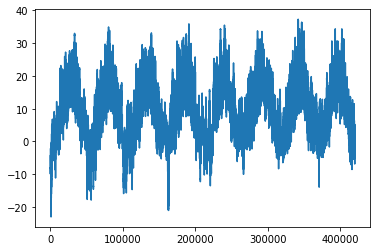

In [5]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

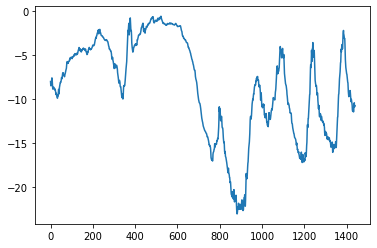

In [6]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [7]:
# dividimos conjunto de entrenamiento, test y validacion
num_train_samples = int(0.5 * len(raw_data)) #50% de train
num_val_samples = int(0.25 * len(raw_data)) # 25% de val
num_test_samples = len(raw_data) - num_train_samples - num_val_samples #25% test
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [8]:
# se estandarizan los daros los datos para obtener un mejor 

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean # se resta la media
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std # dividimos entre la desv estandar 

In [9]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [10]:
sampling_rate = 6 # se toman uno de cada 6 datos, es decir, se toma un dato cada hora
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256


# la siguiente instruccion prepara el conjunto de datos 
# para poderlos trabajar 
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay], # datos cada 10 min, entonces tenemos 700 datos (es mucho)
                       # por eso con en delay reducimos el numero de datos que tenemos 
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True, # aleatorizar como agarro los batchez 
    batch_size = batch_size,
    start_index = 0,
    end_index = num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [11]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

  # primera entrada, 256, registros, en batches de 120, con 14 datos diariso

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline: un baseline es un punto de comparación para mi modelo
MAE**

In [12]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

# esta prediccion supone que la temperatura de mañana será la de hoy
# como una martingala


print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


In [13]:
#### nota: en este caso la variable objetivo no se normaliza, es decir las temperaturas

### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs) #todos los imputs son un vector 
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x) #una sola neurona de salida con activacion lineal
model = keras.Model(inputs, outputs)

callbacks = [ #para guardar el mejor ajuste 
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]

#compilar el modelo
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
# la perdida es la funcion que se busca optimixar
# metric es lo que interesa saber (precision)
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 68s 79ms/step - loss: 11.9751 - mae: 2.6847 - val_loss: 10.8251 - val_mae: 2.5922
Epoch 2/10
819/819 [==============================] - 61s 74ms/step - loss: 8.9226 - mae: 2.3493 - val_loss: 11.6436 - val_mae: 2.6869
Epoch 3/10
819/819 [==============================] - 63s 76ms/step - loss: 8.2741 - mae: 2.2638 - val_loss: 10.4784 - val_mae: 2.5268
Epoch 4/10
819/819 [==============================] - 60s 73ms/step - loss: 7.8365 - mae: 2.2056 - val_loss: 10.6524 - val_mae: 2.5555
Epoch 5/10
819/819 [==============================] - 62s 75ms/step - loss: 7.5004 - mae: 2.1595 - val_loss: 10.5256 - val_mae: 2.5310
Epoch 6/10
819/819 [==============================] - 58s 71ms/step - loss: 7.2739 - mae: 2.1277 - val_loss: 11.1077 - val_mae: 2.6200
Epoch 7/10
819/819 [==============================] - 58s 70ms/step - loss: 7.1048 - mae: 2.1024 - val_loss: 11.5005 - val_mae: 2.6636
Epoch 8/10
819/819 [==============================] - 

**Plotting results**

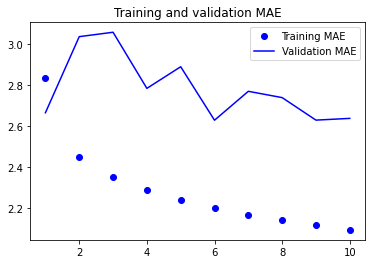

In [14]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

#### modelo convolutivo de 1 dimension, cuando en los de dos dimensiones usabamos ventanas "cubicas", aquí tomaremos ventanas como secuencias de datos

In [1]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# 8 = num_neuronas ,24 = ventana de un día 
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

NameError: ignored

# el resultado es aún peor que el anterior :(, pues ahora el MAE es de 3.22

## qué falló?  
  - no hay invarianza ante traslaciones
  - los datos son distintos por la mañana y la noche
  - el orden de los datos importa
  - los datos más recientes son más importantes que los más antiguos
  - usar maxpooling no ayuda  
  - para el caso de meteorología las redes convolutivas no funciona muy bien 




### A first recurrent baseline

**A simple LSTM-based model**

LSTM = Long short term memory

In [16]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# 16 neuronas
x = layers.LSTM(16)(inputs)
# una neurona de salida, activación lineal
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

#guardar el mejor ajuste 
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 47s 55ms/step - loss: 43.4732 - mae: 4.8136 - val_loss: 13.0965 - val_mae: 2.7481
Epoch 2/10
819/819 [==============================] - 46s 56ms/step - loss: 11.2591 - mae: 2.6094 - val_loss: 9.9642 - val_mae: 2.4592
Epoch 3/10
819/819 [==============================] - 52s 63ms/step - loss: 10.1203 - mae: 2.4841 - val_loss: 9.8194 - val_mae: 2.4381
Epoch 4/10
819/819 [==============================] - 48s 58ms/step - loss: 9.7940 - mae: 2.4464 - val_loss: 9.8400 - val_mae: 2.4370
Epoch 5/10
819/819 [==============================] - 53s 64ms/step - loss: 9.5794 - mae: 2.4203 - val_loss: 9.7767 - val_mae: 2.4317
Epoch 6/10
819/819 [==============================] - 48s 58ms/step - loss: 9.3412 - mae: 2.3891 - val_loss: 9.6233 - val_mae: 2.4196
Epoch 7/10
819/819 [==============================] - 46s 56ms/step - loss: 9.1338 - mae: 2.3580 - val_loss: 9.6421 - val_mae: 2.4226
Epoch 8/10
819/819 [==============================] - 50s 

## Understanding recurrent neural networks

**NumPy implementation of a simple RNN**

In [1]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [4]:
from tensorflow import keras
from tensorflow.keras import layers
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

In [6]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
# return_sequences = False, no regresa la secuencia completa 
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns its full output sequence**

In [7]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking RNN layers**

In [8]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [20]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs) #poner el dropout en cero ayuda 
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5, #originalmente eran 50
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 361s 435ms/step - loss: 27.0502 - mae: 3.8418 - val_loss: 9.6652 - val_mae: 2.4124
Epoch 2/5
819/819 [==============================] - 347s 424ms/step - loss: 14.8162 - mae: 2.9880 - val_loss: 9.6751 - val_mae: 2.4044
Epoch 3/5
819/819 [==============================] - 347s 423ms/step - loss: 14.0014 - mae: 2.8999 - val_loss: 9.4477 - val_mae: 2.3830
Epoch 4/5
819/819 [==============================] - 342s 418ms/step - loss: 13.4167 - mae: 2.8408 - val_loss: 9.4416 - val_mae: 2.3905
Epoch 5/5
819/819 [==============================] - 342s 417ms/step - loss: 12.9582 - mae: 2.7919 - val_loss: 9.3000 - val_mae: 2.3757


In [21]:
inputs = keras.Input(shape=(sequence_length, num_features))
# unroll = true mejora la corrida del modelo 
# pero se sigue tardando años 
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs =  5, #originalmente eran 50
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

### Using bidirectional RNNs

Una red bidireccional puede mejorar los rendidmientos de las redes, son muy utilizadas para el lenguaje natural

**Training and evaluating a bidirectional LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

### Going even further

## Summary